## Dataset Used  
[LFW (Labelled Faces in the Wild)](https://www.kaggle.com/learn)

In [2]:
from pathlib import Path
dataset_path = Path("./lfw")

matchpairs_train_csv = dataset_path / "matchpairsDevTrain.csv"
assert matchpairs_train_csv.exists(), f"Expected {matchpairs_train_csv} to exist."


mismatches_train_csv = dataset_path / "mismatchpairsDevTrain.csv"
assert mismatches_train_csv.exists(), f"Expected {mismatches_train_csv} to exist."

matchpairs_test_csv = dataset_path / "matchpairsDevTest.csv"
assert matchpairs_test_csv.exists(), f"Expected {matchpairs_test_csv} to exist."

mismatches_test_csv = dataset_path / "mismatchpairsDevTest.csv"
assert mismatches_test_csv.exists(), f"Expected {mismatches_test_csv} to exist."

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, classification_report
import random
from tqdm import tqdm

In [4]:
# Configuration
IMG_SIZE = (224, 224)
RESIZED_IMG_SIZE = (96, 96)
BATCH_SIZE = 32

def get_image_path(person_name, image_num):
    """Get the path to an image given person name and image number"""
    img_name = f"{person_name}_{image_num:04d}.jpg"
    return dataset_path / "lfw-deepfunneled" / "lfw-deepfunneled" / person_name / img_name

def load_and_preprocess_image(image_path):
    """Load and preprocess an image"""
    try:
        # Load image
        img = load_img(image_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        # Normalize to [0,1]
        img_array = img_array / 255.0
        # Resize to RESIZED_IMG_SIZE
        img_array = tf.image.resize(img_array, RESIZED_IMG_SIZE)
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        # Return a black image if loading fails
        return np.zeros((*IMG_SIZE, 3))

def load_pairs_data(csv_file, is_match=True):
    """Load pairs data from CSV file"""
    df = pd.read_csv(csv_file)
    pairs = []
    labels = []
    
    for _, row in df.iterrows():
        if is_match:
            # Match pairs: same person, different images
            name = row['name']
            img1_path = get_image_path(name, row['imagenum1'])
            img2_path = get_image_path(name, row['imagenum2'])
            label = 1  # Same person
        else:
            # Mismatch pairs: different persons
            name1 = row.iloc[0]  # First name column
            name2 = row.iloc[2]  # Second name column  
            img1_path = get_image_path(name1, row.iloc[1])  # First image num
            img2_path = get_image_path(name2, row.iloc[3])  # Second image num
            label = 0  # Different persons
        
        pairs.append((img1_path, img2_path))
        labels.append(label)
    
    return pairs, labels

In [19]:
# Load training data
print("Loading training data...")
match_pairs_train, match_labels_train = load_pairs_data(matchpairs_train_csv, is_match=True)
mismatch_pairs_train, mismatch_labels_train = load_pairs_data(mismatches_train_csv, is_match=False)

# Combine training data
train_pairs = match_pairs_train + mismatch_pairs_train
train_labels = match_labels_train + mismatch_labels_train

print(f"Training data: {len(train_pairs)} pairs")
print(f"Positive pairs (same person): {sum(train_labels)}")
print(f"Negative pairs (different person): {len(train_labels) - sum(train_labels)}")

# Load test data
print("\nLoading test data...")
match_pairs_test, match_labels_test = load_pairs_data(matchpairs_test_csv, is_match=True)
mismatch_pairs_test, mismatch_labels_test = load_pairs_data(mismatches_test_csv, is_match=False)

# Combine test data
test_pairs = match_pairs_test + mismatch_pairs_test
test_labels = match_labels_test + mismatch_labels_test

print(f"Test data: {len(test_pairs)} pairs")
print(f"Positive pairs (same person): {sum(test_labels)}")
print(f"Negative pairs (different person): {len(test_labels) - sum(test_labels)}")

Loading training data...
Training data: 2200 pairs
Positive pairs (same person): 1100
Negative pairs (different person): 1100

Loading test data...
Test data: 1000 pairs
Positive pairs (same person): 500
Negative pairs (different person): 500


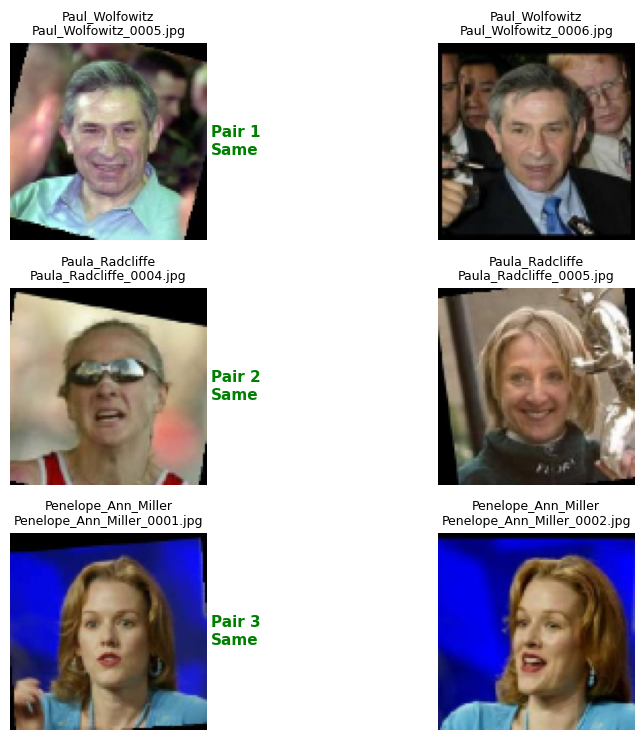

In [20]:
import numpy as np

# visualize some pairs (improved: show names, filenames and colored borders for easy distinction)

def visualize_pairs(pairs, labels, num_pairs=5):
    """Visualize pairs of images with readable info and colored border:
       green = same person, red = different persons"""
    num_pairs = min(num_pairs, len(pairs))
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, num_pairs * 2.5))
    if num_pairs == 1:
        axes = axes.reshape(1, 2)
    
    for i in range(num_pairs):
        img1_path, img2_path = pairs[i]
        true_label = int(labels[i])
        label_str = "Same" if true_label == 1 else "Different"
        color = "green" if true_label == 1 else "red"
        
        img1 = np.array(load_and_preprocess_image(img1_path))
        img2 = np.array(load_and_preprocess_image(img2_path))
        
        ax1, ax2 = axes[i, 0], axes[i, 1]
        ax1.imshow(np.clip(img1, 0, 1))
        ax1.axis("off")
        ax1.set_title(f"{img1_path.parent.name}\n{img1_path.name}", fontsize=9)
        
        ax2.imshow(np.clip(img2, 0, 1))
        ax2.axis("off")
        ax2.set_title(f"{img2_path.parent.name}\n{img2_path.name}", fontsize=9)
        
        # make spines visible and colored so the pair is distinguishable at a glance
        for ax in (ax1, ax2):
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_edgecolor(color)
                spine.set_linewidth(3)
        
        # add pair label between the two images
        ax1.text(1.02, 0.5, f"Pair {i+1}\n{label_str}", transform=ax1.transAxes,
                 va="center", fontsize=11, color=color, weight="bold")
    
    plt.tight_layout()
    plt.show()

# Example call (keep same slice as before)
random_index = random.randint(0, len(train_pairs) - 4)
visualize_pairs(train_pairs[random_index:], train_labels[random_index:], num_pairs=3)

In [21]:
import random
import tensorflow as tf


def create_tf_dataset(
    pairs,
    labels,
    batch_size=32,
    shuffle=True,
    buffer_size=None,  # if None, will default to len(pairs) when shuffling
):
    """
    Create a tf.data.Dataset of ((img1, img2), label) where:
      - img1/img2: float32 tensors of shape (H, W, 3)
      - label: float32 tensor of shape (1,)
    """


    def generator():
        indices = list(range(len(pairs)))
        if shuffle:
            random.shuffle(indices)

        for i in indices:
            img1_path, img2_path = pairs[i]
            y = labels[i]

            # Must return float32 of shape (H, W, 3)
            img1 = load_and_preprocess_image(
                img1_path
            )  # ensure it outputs (H,W,3) float32
            img2 = load_and_preprocess_image(img2_path)

            # Ensure label is float32 and shape (1,)
            y = tf.cast(y, tf.float32)
            y = tf.reshape(y, (1,))  # or keep scalar if your loss expects that

            yield (img1, img2), y

    output_signature = (
        (
            tf.TensorSpec(shape=(*RESIZED_IMG_SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(*RESIZED_IMG_SIZE, 3), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(1,), dtype=tf.float32),
    )

    dataset = tf.data.Dataset.from_generator(
        generator, output_signature=output_signature
    )

    if shuffle:
        if buffer_size is None:
            buffer_size = len(pairs)
        dataset = dataset.shuffle(
            buffer_size=buffer_size, reshuffle_each_iteration=True
        )

    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


# Example usage:
# If your model resizes 256->96 internally, set img_size=(256,256)
train_dataset = create_tf_dataset(train_pairs, train_labels, batch_size=BATCH_SIZE, shuffle=True)
test_dataset  = create_tf_dataset(test_pairs,  test_labels,  batch_size=BATCH_SIZE, shuffle=False)

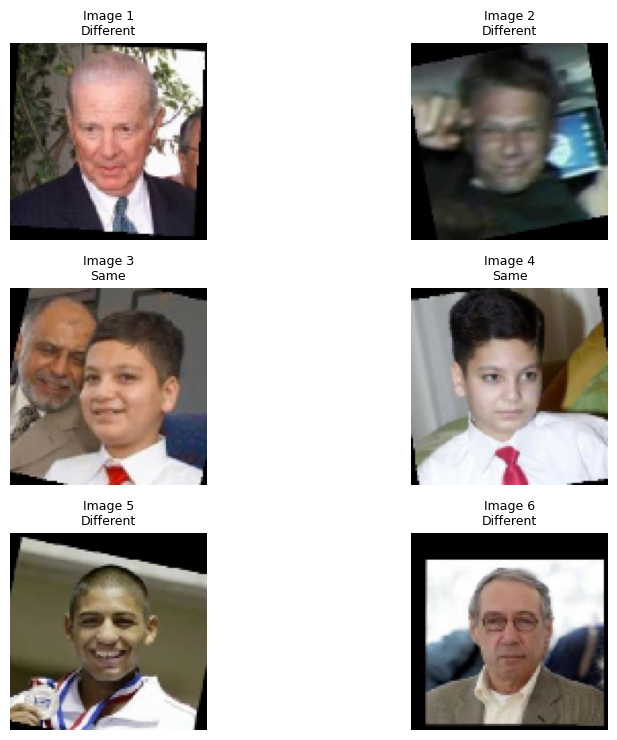

In [23]:
# visualize some pairs from the tf train_dataset
def visualize_tf_pairs(dataset, num_pairs=5):
    """Visualize pairs from a TensorFlow dataset.
       Note: tf.data.Dataset has unknown length, and `dataset` may be batched.
       We unbatch and take up to num_pairs samples to avoid using len(dataset)."""
    # Collect up to num_pairs samples from the (possibly batched) dataset
    samples = []
    for pair, label in dataset.unbatch().take(num_pairs):
        samples.append((pair, label))
    if len(samples) == 0:
        print("No samples available in the dataset to visualize.")
        return

    n = len(samples)
    fig, axes = plt.subplots(n, 2, figsize=(10, n * 2.5))
    if n == 1:
        axes = axes.reshape(1, 2)

    for i, (pair, label) in enumerate(samples):
        img1, img2 = pair
        true_label = int(label.numpy().reshape(-1)[0])
        label_str = "Same" if true_label == 1 else "Different"
        color = "green" if true_label == 1 else "red"

        ax1, ax2 = axes[i, 0], axes[i, 1]
        ax1.imshow(np.clip(img1.numpy(), 0, 1))
        ax1.axis("off")
        ax1.set_title(f"Image {i*2+1}\n{label_str}", fontsize=9)

        ax2.imshow(np.clip(img2.numpy(), 0, 1))
        ax2.axis("off")
        ax2.set_title(f"Image {i*2+2}\n{label_str}", fontsize=9)

        # make spines visible and colored so the pair is distinguishable at a glance
        for ax in (ax1, ax2):
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_edgecolor(color)
                spine.set_linewidth(3)

    plt.tight_layout()
    plt.show()

# Example call to visualize pairs from the TensorFlow dataset
visualize_tf_pairs(train_dataset, num_pairs=3)

### Model building

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7
    )
]

# Train the model
EPOCHS = 50
print("Starting training...")

history = siamese_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
print("Evaluating model on test data...")
test_loss, test_accuracy = siamese_model.evaluate(test_dataset, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
def visualize_predictions(pairs, labels, predictions, num_samples=8):
    """Visualize some predictions with their images"""
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(min(num_samples, len(pairs))):
        img1_path, img2_path = pairs[i]
        true_label = labels[i]
        pred_score = predictions[i]
        pred_label = 1 if pred_score > 0.5 else 0
        
        # Load images
        img1 = load_and_preprocess_image(img1_path)
        img2 = load_and_preprocess_image(img2_path)
        
        # Plot images
        axes[i, 0].imshow(img1)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Image 1\n{img1_path.parent.name}')
        
        axes[i, 1].imshow(img2)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f'Image 2\n{img2_path.parent.name}')
        
        # Add prediction info
        status = "✓" if pred_label == true_label else "✗"
        result = "Same" if pred_label == 1 else "Different"
        true_result = "Same" if true_label == 1 else "Different"
        
        fig.suptitle(f'Row {i+1}: Pred: {result} (Score: {pred_score:.3f}) | True: {true_result} | {status}', 
                    y=1 - (i + 0.5) / num_samples, fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Make predictions on a subset of test data
print("Making predictions on test samples...")
sample_size = 100
sample_indices = random.sample(range(len(test_pairs)), min(sample_size, len(test_pairs)))
sample_pairs = [test_pairs[i] for i in sample_indices]
sample_labels = [test_labels[i] for i in sample_indices]

# Create dataset for predictions
sample_dataset = create_tf_dataset(sample_pairs, sample_labels, BATCH_SIZE, shuffle=False)

# Get predictions
predictions = siamese_model.predict(sample_dataset, verbose=0)
predictions = predictions.flatten()

# Convert to binary predictions
binary_predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(sample_labels, binary_predictions)
print(f"Sample accuracy: {accuracy:.4f}")

# Visualize some predictions
print("Visualizing some predictions...")
visualize_predictions(sample_pairs[:8], sample_labels[:8], predictions[:8])

In [ ]:
# Save the trained model
print("Saving the trained model...")
siamese_model.save('siamese_face_verification_model.h5')
base_network.save('siamese_base_network.h5')
print("Models saved successfully!")

print("\n" + "="*60)
print("SIAMESE NETWORK TRAINING COMPLETE!")
print("="*60)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Model saved as: siamese_face_verification_model.h5")
print(f"Base network saved as: siamese_base_network.h5")
print("="*60)